# Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import time
import json
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
from xskillscore import crps_quadrature, crps_ensemble

import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))
from modules.architectures import *

from modules.swag import data, models, utils, losses
from modules.swag.posteriors import SWAG

import modules.architectures as modelArchitectures
from modules.full_pipeline import compute_errors, _inner
from modules.plotting import plot_intervalmap, plot_signal, plot_rmses
from modules.data import hp_to_equiangular
from modules.test import compute_rmse_healpix, compute_R2, compute_rmse_equiangular, compute_weighted_rmse

# Config

In [3]:
config_file = 'config_s01_two_steps_small.json'
ep = 11
lead_time = 6

# load config
with open("../configs/" + config_file) as json_data_file:
    cfg = json.load(json_data_file)

# define paths
datadir = cfg['directories']['datadir']
input_dir = datadir + cfg['directories']['input_dir']
model_save_path = datadir + cfg['directories']['model_save_path']
pred_save_path = datadir + cfg['directories']['pred_save_path']
metrics_path = datadir + cfg['directories']['metrics_path']

# model parameters
max_lead_time = cfg['training_constants']['max_lead_time']
len_sqce = cfg['model_parameters']['len_sqce']
delta_t = cfg['model_parameters']['delta_t']
architecture_name = cfg['model_parameters']['architecture_name']
resolution = cfg['model_parameters']['resolution']

# RMSE Skill Score

In [4]:
rmses_weyn = xr.open_dataset(datadir + 'metrics/rmses_weyn.nc')

## Compute reference RMSEs

In [5]:
# Load observations in equiangular
obs_equi = xr.open_dataset(pred_save_path + 'observations_equi.nc')

### Climatology

In [6]:
climatology = xr.open_dataset("../data/models/baselines/weekly_climatology_5.625.nc").drop('level').drop('week')
climatology = climatology[['z', 't']]
climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 ...
    t        (time, lat, lon) float32 ...

In [7]:
def create_clim_forecast(ds, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    ds_fc = ds.isel(time=slice(0, -lead_time_h))
    return ds_fc

lead_times = xr.DataArray(
    np.arange(6, 126, 6), dims=['lead_time'], coords={'lead_time': np.arange(6, 126, 6)}, name='lead_time')

climatology_ds = []
for l in lead_times:
    climatology_ds.append(create_clim_forecast(climatology, int(l)))
climatology_ds = xr.concat(climatology_ds, dim=lead_times)

climatology_ds

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 20, lon: 64, time: 17514)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T17:00:00
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z          (lead_time, time, lat, lon) float32 50208.12 50222.945 ... nan
    t          (lead_time, time, lat, lon) float32 256.2407 256.28226 ... nan

In [8]:
# Get common time and lead time
common_time = list(set(climatology_ds.time.values).intersection(obs_equi.time.values))
common_time.sort()

common_lead_time = list(set(climatology_ds.lead_time.values).intersection(obs_equi.lead_time.values))
common_lead_time.sort()

climatology_ds = climatology_ds.sel(dict(time=common_time, lead_time=common_lead_time))
obs_equi = obs_equi.sel(dict(time=common_time, lead_time=common_lead_time)).load()
reference_rmses = rmses_weyn.rename({'z500':'z', 't850':'t'}).sel(lead_time=common_lead_time)

In [9]:
rmse_climatology = compute_weighted_rmse(climatology_ds, obs_equi, dims=('lat', 'lon', 'time'))

In [10]:
rmse_climatology

<xarray.Dataset>
Dimensions:    (lead_time: 20)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Data variables:
    z          (lead_time) float64 757.2 757.1 757.0 756.9 ... 757.8 758.0 758.3
    t          (lead_time) float64 3.098 3.098 3.099 3.1 ... 3.127 3.13 3.133

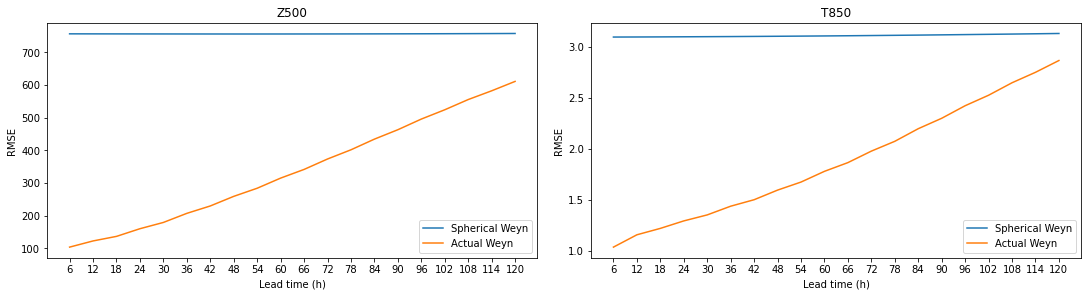

In [11]:
plot_rmses(rmse_climatology, reference_rmses, lead_time=6, max_lead_time=max_lead_time)

In [16]:
rmse_climatology.to_netcdf(datadir + 'metrics/rmse_climatology.nc')

### Persistence

In [12]:
persistence = xr.open_dataset("../data/models/baselines/persistence_5.625.nc")
persistence = persistence[['z', 't']]
persistence

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 20, lon: 64, time: 17514)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T17:00:00
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z          (lead_time, time, lat, lon) float32 ...
    t          (lead_time, time, lat, lon) float32 ...

In [13]:
common_time = list(set(persistence.time.values).intersection(obs_equi.time.values))
common_time.sort()

common_lead_time = list(set(persistence.lead_time.values).intersection(obs_equi.lead_time.values))
common_lead_time.sort()

persistence = persistence.sel(dict(time=common_time, lead_time=common_lead_time))
obs_equi = obs_equi.sel(dict(time=common_time, lead_time=common_lead_time)).load()

In [14]:
rmse_persistence = compute_weighted_rmse(persistence, obs_equi, dims=('lat', 'lon', 'time'))

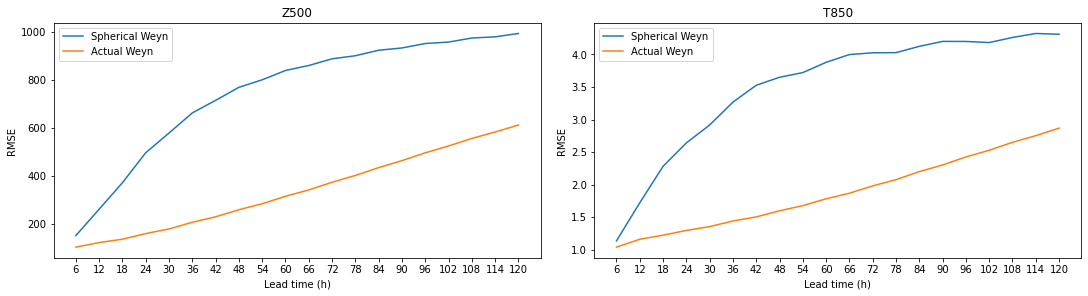

In [15]:
plot_rmses(rmse_persistence, reference_rmses, lead_time=6, max_lead_time=max_lead_time)

In [17]:
rmse_persistence.to_netcdf(datadir + 'metrics/rmse_persistence.nc')

## Models RMSE SS

In [28]:
description_epoch = "all_const_len{}_delta_{}_architecture_".format(len_sqce, delta_t) + architecture_name
descriptions = [
    description_epoch + f'_s02_epoch_{ep}',
    description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag',
    description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag_scale001_median',
    description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag_scale01_median',
    description_epoch + f'_s02_swag_freq10_epoch_{ep}_swag_scale03_median',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale00_median',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale01_median',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale01_aggregate_median',
    description_epoch + f'_s02_ensemble_epoch_{ep}_median',
    description_epoch + f'_s02_fixed_data_ensemble_ensemble_epoch_{ep}_median'
]

file_paths = []

for description in descriptions:
    rmse_filename = datadir + 'metrics/rmse_' + description + '.nc'    
    file_paths.append(rmse_filename)

rmses = []
    
for path in file_paths:
    rmse = xr.open_dataset(path)
    rmses.append(rmse)

rmses_ss_clim = []
rmses_ss_persistence = []

for rmse in rmses:
    rmse_ss_clim = 1 - (rmse/rmse_climatology)
    rmse_ss_persistence = 1 - (rmse/rmse_persistence)
    rmses_ss_clim.append(rmse_ss_clim)
    rmses_ss_persistence.append(rmse_ss_persistence)

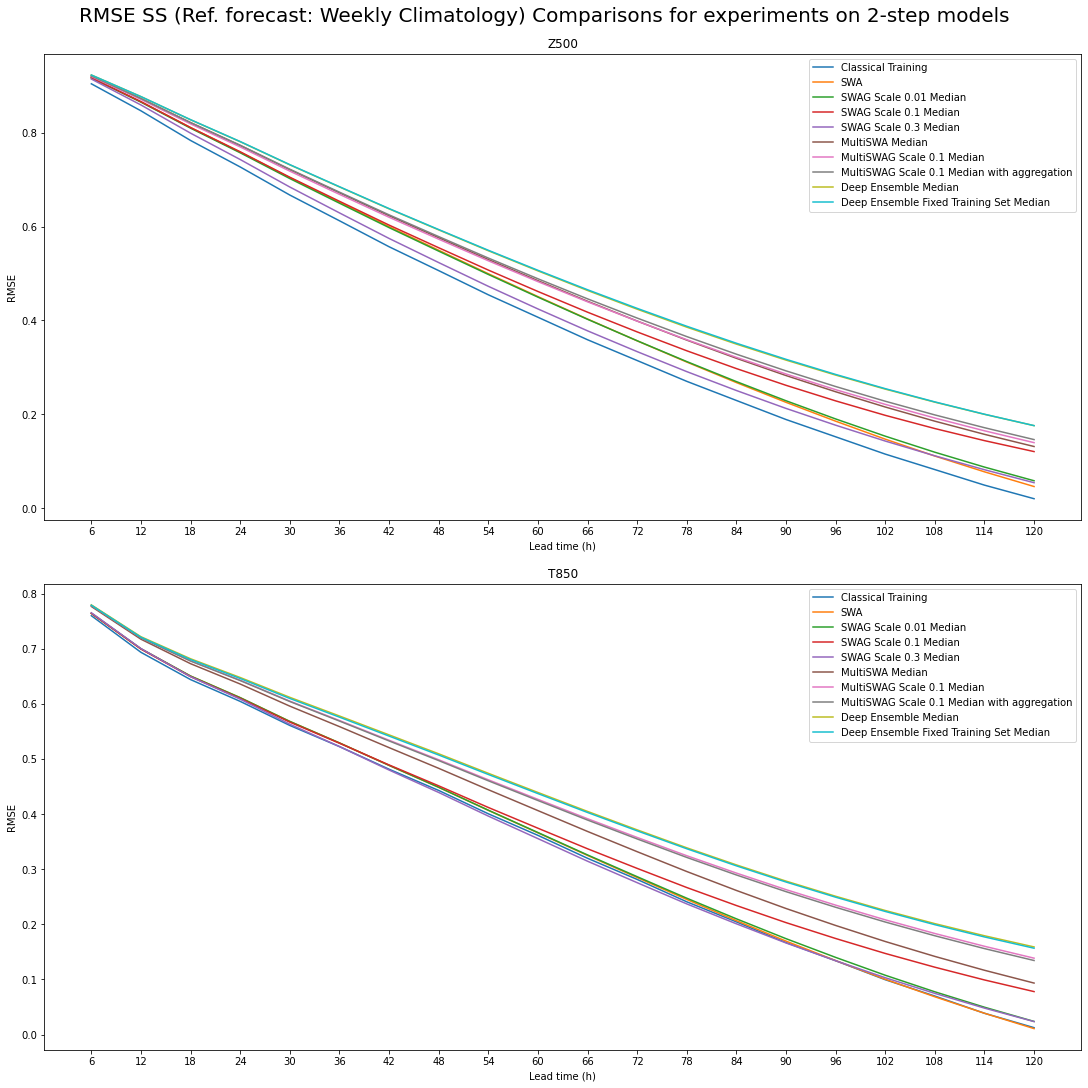

In [29]:
labels = [
    'Classical Training',
    'SWA',
    'SWAG Scale 0.01 Median',
    'SWAG Scale 0.1 Median',
    'SWAG Scale 0.3 Median',
    'MultiSWA Median',
    'MultiSWAG Scale 0.1 Median',
    'MultiSWAG Scale 0.1 Median with aggregation',
    'Deep Ensemble Median',
    'Deep Ensemble Fixed Training Set Median'
]

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)
    
lead_times = np.arange(lead_time, max_lead_time + lead_time, lead_time)

for i, rmse in enumerate(rmses_ss_clim):
    ax1.plot(lead_times, rmse.z.values, label=labels[i])
    
for i, rmse in enumerate(rmses_ss_clim):
    ax2.plot(lead_times, rmse.t.values, label=labels[i])

ax1.set_xlabel('Lead time (h)')
ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax2.set_xlabel('Lead time (h)')
ax1.set_ylabel('RMSE')
ax2.set_ylabel('RMSE')
ax1.set_title('Z500')
ax2.set_title('T850')

f.suptitle('RMSE SS (Ref. forecast: Weekly Climatology) Comparisons for experiments on 2-step models', 
           fontsize=20)
ax1.legend()
ax2.legend()
plt.show()

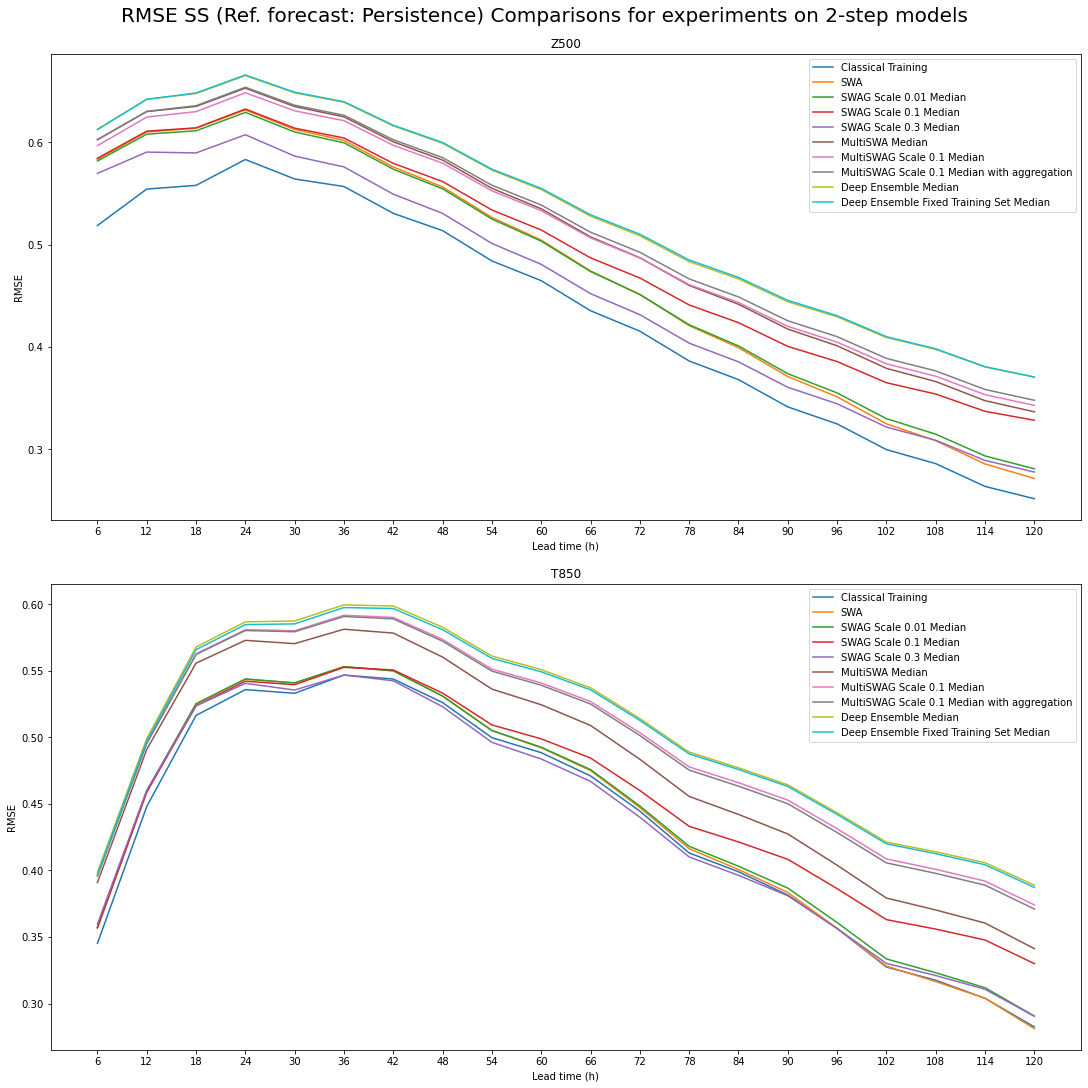

In [30]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), constrained_layout=True)
    
lead_times = np.arange(lead_time, max_lead_time + lead_time, lead_time)

for i, rmse in enumerate(rmses_ss_persistence):
    ax1.plot(lead_times, rmse.z.values, label=labels[i])
    
for i, rmse in enumerate(rmses_ss_persistence):
    ax2.plot(lead_times, rmse.t.values, label=labels[i])

ax1.set_xlabel('Lead time (h)')
ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax2.set_xlabel('Lead time (h)')
ax1.set_ylabel('RMSE')
ax2.set_ylabel('RMSE')
ax1.set_title('Z500')
ax2.set_title('T850')

f.suptitle('RMSE SS (Ref. forecast: Persistence) Comparisons for experiments on 2-step models', 
           fontsize=20)
ax1.legend()
ax2.legend()
plt.show()